These are all libraries we need to construct a neural network.

In [66]:
import numpy as np

In [65]:
# Auxiliars
## Visualisation
import pandas as pd
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt

## Manage Files
import os

## HyperParameters

In [187]:
ds_volume = 1.00                        # percentage of data used as dataset
threshold = 0.50                        # percentage of dataset used in training (vs. test)

dimensions = [400, 14, 10]              # size of each layer
alpha = 2.0                             # learning rate
lambda_t = 1.2e-2                       # L2 regularization parameter

steps = 200                             # number of iterations until stop

In [188]:
def to_multiclass(y, shape):
    ''' Convert an array of labels e.g. [1, 2, 9, 0, 6] in a table
        in which each row is an item from the list and each column
        is a digit (0-9). That table has value 1 for each row in
        the corresponing digit and 0 elsewhere.
    '''
    Y = np.zeros(shape)
    for i in range(y.shape[0]):
        Y[i, y[i]-1] = 1
    return Y

In [189]:
# Load data from .csv
all_x = np.genfromtxt('dataset/numbers.csv', delimiter=',')
all_y = np.genfromtxt('dataset/labels.csv', delimiter=',', dtype=np.int)

# Normalization 0-1
all_x = all_x.T
all_x = (all_x-all_x.min(0)) / all_x.ptp(0)
all_x = all_x.T

size = np.ceil(all_x.shape[0] * ds_volume)
indexes = np.random.choice(all_x.shape[0], size=size.astype(np.int), replace=False).astype(np.int)
thres = np.ceil(size * threshold).astype(np.int)

# Separate Training Set From Validation Set
ts = indexes[:thres]
vd = indexes[thres:]

# Dataset creation
dataset_i = all_x[ts]
dataset_o = all_y[ts]
dataset_o = to_multiclass(dataset_o, (dataset_o.shape[0], 10))

## Examples visualisation

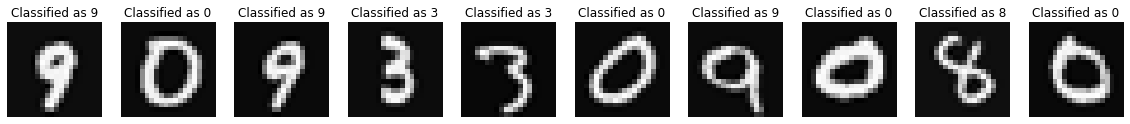

In [190]:
n_examples = 10
examples = np.random.choice(ts, n_examples)

plt.subplots(1, n_examples, figsize=(20, 4))
for i, example in enumerate(examples):
    plt.subplot(1, n_examples, i+1)
    plt.imshow(all_x[example].reshape(20, 20).T, cmap="gray")
    plt.title("Classified as {}".format(all_y[example] % 10))
    plt.axis('off')

## Initialization

In [191]:
theta = [[]]*(len(dimensions)-1)                     # Tensor of weights

for l in range(len(theta)):                          # Initialisation of weights: N(0, 1)
    theta[l] = np.random.normal(size=(dimensions[l]+1, dimensions[l+1]))  

# Functions for training

In [192]:
def front_propagation(X, theta):
    s = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    a = [s]
    for theta_l in theta:
        s = sigmoid(s.dot(theta_l))
        s = np.concatenate((np.ones((s.shape[0], 1)), s), axis=1)
        a.append(s)
    a[-1] = np.delete(a[-1], 0, 1)
    return a

In [193]:
sigmoid = np.vectorize(lambda z: 1 / (1 + np.exp(-z)))

In [194]:
def cost(a, y, theta, lambda_t):
    m = y.shape[0]
    y = (y - 0.5)* 2
    y = y * a[-1]
    dcost = np.vectorize(lambda h: np.log(h) if h > 0 else np.log(1 + h))
    y = dcost(y)
    cost = -np.sum(y)
    for theta_l in theta:
        cost += lambda_t / 2 * np.sum(list(map(lambda x: x ** 2, theta_l)))
    return cost/m

In [195]:
def grad(a, y, theta, lambda_t):
    m = y.shape[0]
    d = [[]]*(len(theta))
    d[-1] = a[-1] - y
    for l in range(len(theta)-1, 0, -1):
        s = d[l]
        if l != len(theta)-1:
            s = np.delete(d[l], 0, 1)
        d[l-1] = s.dot(theta[l].T) * a[l] * (np.ones(a[l].shape) - a[l])
    D = [[]]*len(theta)
    D[-1] = np.sum(d[-1], axis=0)/m
    for l in range(len(d)-1, -1, -1):
        s = d[l]
        if l != len(d)-1:
            s = np.delete(s, 0, 1)
        D[l] = a[l].T.dot(s)/m
        zeros = np.zeros((1, theta[l].shape[1]))
        thets = np.delete(theta[l], 0, 0)
        D[l] += lambda_t * np.concatenate((zeros, thets), axis=0)
    return D

In [196]:
def numerical_grad(a, y, theta, lambda_t):
    e = 1e-4
    it = 0
    for l, theta_l in enumerate(theta):
        for i, row in enumerate(theta_l):
            for j, col in enumerate(row):
                theta[l][i][j] += e
                a[0] = np.delete(a[0], 0, 1)
                a = front_propagation(a[0], theta)
                cost_p = cost(a, y, theta, lambda_t)
                theta[l][i][j] -= 2 * e
                a[0] = np.delete(a[0], 0, 1)
                a = front_propagation(a[0], theta)
                cost_m = cost(a, y, theta, lambda_t)
                theta[l][i][j] += e
                grad = (cost_p - cost_m) / 2 / e
                yield (it, l, i, j, grad)
                it += 1

In [197]:
def shape(v, text):
    print("{}: ".format(text), end=' ')
    for i in v:
        print(i.shape, end=' ')
    print()

# Training

In [198]:
# training
costs = pd.Series(index=[0])
for i in trange(steps):
    a = front_propagation(dataset_i, theta)
    costs[i] = cost(a, dataset_o, theta, lambda_t)
    g1 = grad(a, dataset_o, theta, lambda_t)
    for l in range(len(theta)):
        theta[l] -= g1[l] * alpha

if False: # DEBUG
    for it, l, i, j, num_grad in numerical_grad(a, dataset_o, theta, lambda_t):
        print("#[{:02d}][{:02d}][{:02d}] {:11.8f} =>{:11.8f} ({:}%)".format(l, i, j, 
                g1[l][i][j], num_grad, (g1[l][i][j] - num_grad)/num_grad*100))
        if it > 20:
            break

100%|██████████| 200/200 [01:16<00:00,  2.63it/s]


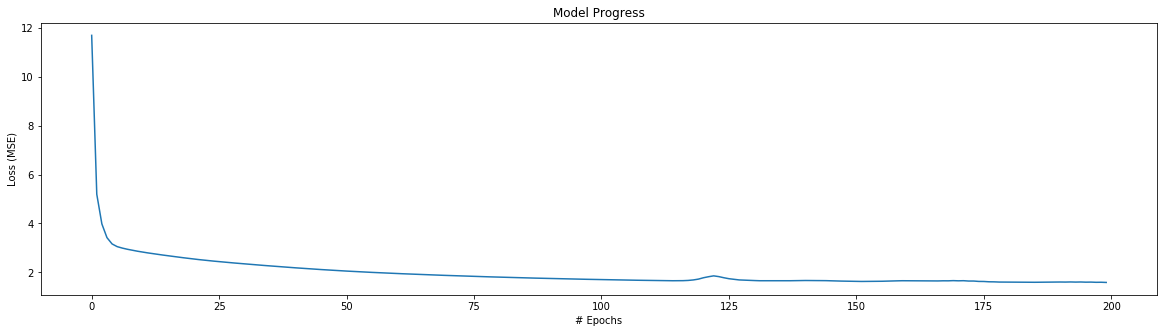

In [199]:
plt.figure(figsize=(20, 5))
plt.plot(costs)
plt.title('Model Progress')
plt.ylabel('Loss (MSE)')
plt.xlabel('# Epochs')
plt.show();

## Validation

In [200]:
hyperp_filename = 'hyperparameters.csv'
if os.path.exists(hyperp_filename):
    hyperp = pd.read_csv(hyperp_filename)
else:
    hyperp = pd.DataFrame(index=[], columns=["ds_volume", "threshold", "layers", "nodes_per_layer", "alpha", "lambda_t", "steps", "accuracy", "cost_ts", "cost_vd"])

In [201]:
test_i = all_x[vd]
test_o = all_y[vd]
test_o = to_multiclass(test_o, (test_o.shape[0], theta[-1].shape[1]))

guesses = np.zeros((test_o.shape[1]+1, test_o.shape[1]+1))

hipothesis = front_propagation(test_i, theta)[-1]
for i in range(hipothesis.shape[0]):
    guesses[np.argmax(test_o[i])+1, np.argmax(hipothesis[i])+1] += 1

accuracy = guesses.trace()/np.sum(guesses)*100
print("Accuracy: {:2.2f}%".format(accuracy))
print("Cost dataset   : {:.2f}".format(cost_ts))
cost_vd = cost(hipothesis, test_o, theta, lambda_t)
print("Cost validation: {:.2f}".format(cost_vd))

display(pd.DataFrame(guesses))

# saving
hyperp = hyperp.append({
    'ds_volume':ds_volume,
    'threshold':threshold,
    'layers': len(dimensions),
    'nodes_per_layer': dimensions[1],
    'alpha': alpha,
    'lambda_t': lambda_t,
    'steps': steps,
    'accuracy': accuracy,
    'cost_ts': cost_ts,
    'cost_vd': cost_vd
}, ignore_index=True)
hyperp.to_csv(hyperp_filename, index=None)
display(hyperp.sort_values(by='cost_vd', ascending=True))

Accuracy: 81.96%
Cost dataset   : 1.52
Cost validation: 4.48


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,243.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0
2,0.0,8.0,230.0,3.0,5.0,0.0,4.0,5.0,1.0,0.0,6.0
3,0.0,5.0,14.0,226.0,0.0,5.0,1.0,5.0,0.0,0.0,3.0
4,0.0,5.0,6.0,0.0,220.0,2.0,8.0,3.0,0.0,5.0,2.0
5,0.0,6.0,2.0,33.0,3.0,178.0,9.0,0.0,0.0,0.0,25.0
6,0.0,7.0,3.0,0.0,0.0,4.0,223.0,0.0,0.0,0.0,4.0
7,0.0,17.0,3.0,0.0,2.0,1.0,0.0,222.0,0.0,0.0,3.0
8,0.0,21.0,12.0,42.0,0.0,11.0,3.0,1.0,146.0,6.0,4.0
9,0.0,5.0,0.0,3.0,17.0,4.0,2.0,83.0,1.0,116.0,7.0


,ds_volume,threshold,layers,nodes_per_layer,alpha,lambda_t,steps,accuracy,cost_ts,cost_vd
5,1.0,0.5,3.0,14.0,1.0,0.100,200.0,9.44,1.516239,3.255590
2,1.0,0.5,3.0,14.0,0.1,0.010,200.0,37.28,1.516239,3.437609
3,1.0,0.5,3.0,14.0,1.0,0.010,200.0,83.92,1.516239,3.814707
0,1.0,0.5,3.0,14.0,2.0,0.010,200.0,84.08,1.516239,4.160384
6,1.0,0.5,3.0,14.0,2.0,0.012,200.0,81.96,1.516239,4.478654
1,1.0,0.5,4.0,120.0,2.0,0.010,200.0,67.48,1.516239,4.785977
4,1.0,0.5,3.0,14.0,1.0,0.001,200.0,78.40,1.516239,6.431485


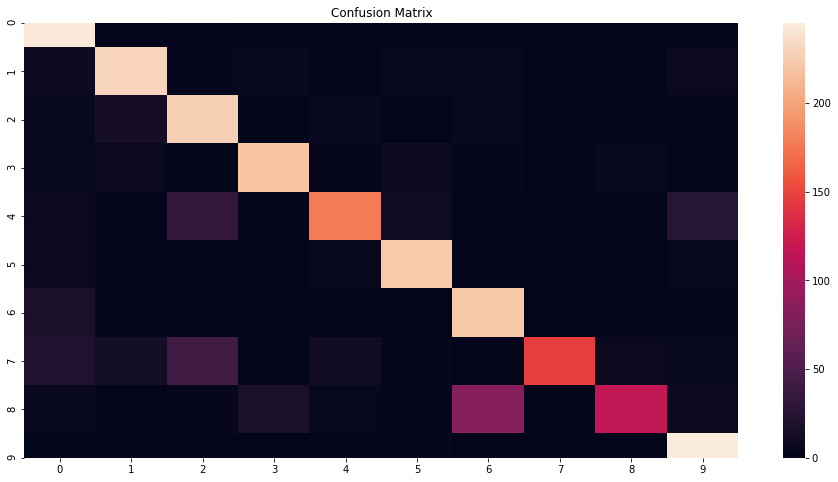

In [202]:
plt.figure(figsize=(16, 8))
sns.heatmap(guesses[1:, 1:])
plt.title('Confusion Matrix')
plt.show();

In [203]:
hyperp.sort_values(by='accuracy', ascending=False).head()

,ds_volume,threshold,layers,nodes_per_layer,alpha,lambda_t,steps,accuracy,cost_ts,cost_vd
0,1.0,0.5,3.0,14.0,2.0,0.010,200.0,84.08,1.516239,4.160384
3,1.0,0.5,3.0,14.0,1.0,0.010,200.0,83.92,1.516239,3.814707
6,1.0,0.5,3.0,14.0,2.0,0.012,200.0,81.96,1.516239,4.478654
4,1.0,0.5,3.0,14.0,1.0,0.001,200.0,78.40,1.516239,6.431485
1,1.0,0.5,4.0,120.0,2.0,0.010,200.0,67.48,1.516239,4.785977


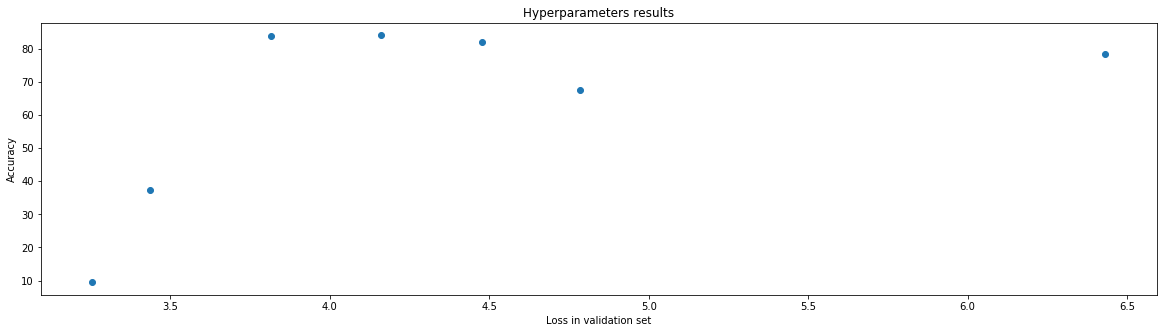

In [204]:
plt.figure(figsize=(20, 5))
plt.scatter(hyperp['cost_vd'], hyperp['accuracy'])
plt.title('Hyperparameters results')
plt.xlabel('Loss in validation set')
plt.ylabel('Accuracy')
plt.show();

## Experiment #1 - What regions does the neural network looks for?

If we set a defined value output as answer and run the neural network backwards, we will produce an image. This image represents the regions in which the neural network "directs" its weights to decide the defined output, i.e., the most important regions for each digit.

In [205]:
# Set a digit value here
digit = 3

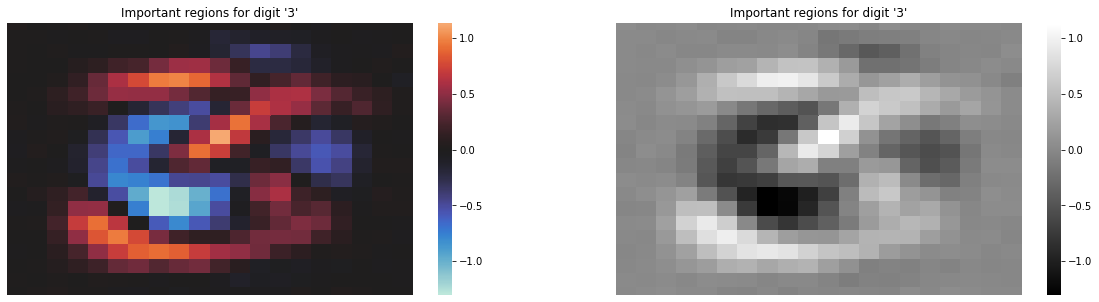

In [206]:
out_tensor = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
out_tensor[digit - 1] = 1 
k = []
k.append(np.dot(out_tensor, theta[1].T))
k[0] = k[0][1:]
k.append(np.dot(k[0], theta[0].T))
k[1] = k[1][1:]

plt.subplots(1, 2, figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.heatmap(k[1].reshape(20, 20).T, center=0)
plt.title("Important regions for digit '{}'".format(digit))
plt.axis('off')
plt.subplot(1, 2, 2)
sns.heatmap(k[1].reshape(20, 20).T, cmap='gray')
plt.title("Important regions for digit '{}'".format(digit))
plt.axis('off')
plt.show();

In [ ]:
.